In [1]:
import pandas as pd  #pandas library to be able to work with dataframes
import numpy as np # for mathematical calculations
import missingno as msno # to check missing values

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler #scaling dataset

#For modeling
from sklearn.model_selection import train_test_split # splitting dataset (train and test)
from xgboost import XGBRegressor #for building regression model

#evaluation regression model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
%matplotlib inline

# Data Understanding

In [2]:
data = pd.read_csv('train.csv')
df = data.copy()

In [3]:
df.head()

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,...,"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII),y
0,990025,Large Magellanic Cloud (LMC),0.628657,63.125200,27109.234310,0.646039,8.240543,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052590
1,990025,Camelopardalis B,0.818082,81.004994,30166.793958,0.852246,10.671823,4.742470,0.833624,0.467873,...,NaN,NaN,NaN,NaN,NaN,19.177926,NaN,22.785018,NaN,0.059868
2,990025,Virgo I,0.659443,59.570534,8441.707353,0.499762,8.840316,5.583973,0.469110,0.363837,...,NaN,NaN,NaN,NaN,NaN,21.151265,6.534020,NaN,NaN,0.050449
3,990025,UGC 8651 (DDO 181),0.555862,52.333293,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.912194,NaN,NaN,0.049394
4,990025,Tucana Dwarf,0.991196,81.802464,81033.956906,1.131163,13.800672,13.188907,0.910341,0.918353,...,NaN,NaN,NaN,NaN,NaN,NaN,5.611753,NaN,NaN,0.154247


## Checking missing values

<AxesSubplot:>

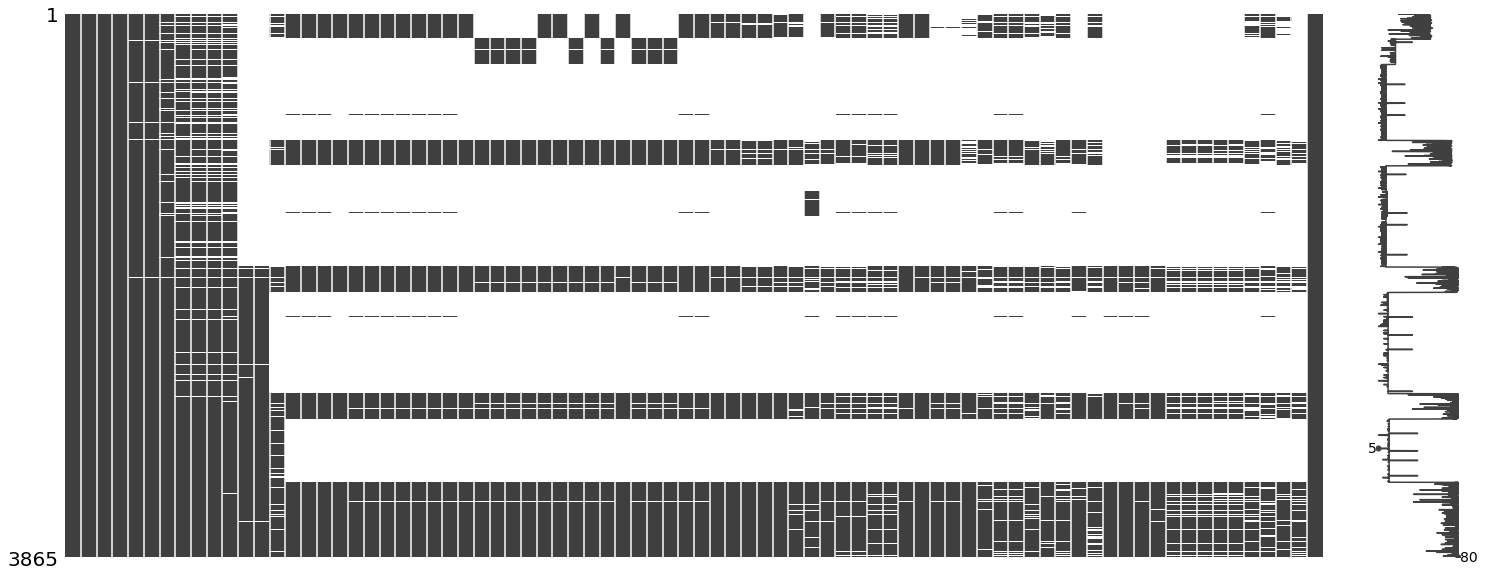

In [4]:
msno.matrix(df)

### Selecting unnecessary columns

In [5]:
to_drop = []
for i in df.columns:
    if df.iloc[:][i].isnull().sum()/df.shape[0] >=0.3:
        to_drop.append(i)

In [6]:
#droping selected columns
df.drop(to_drop, axis = 1, inplace = True)

<AxesSubplot:>

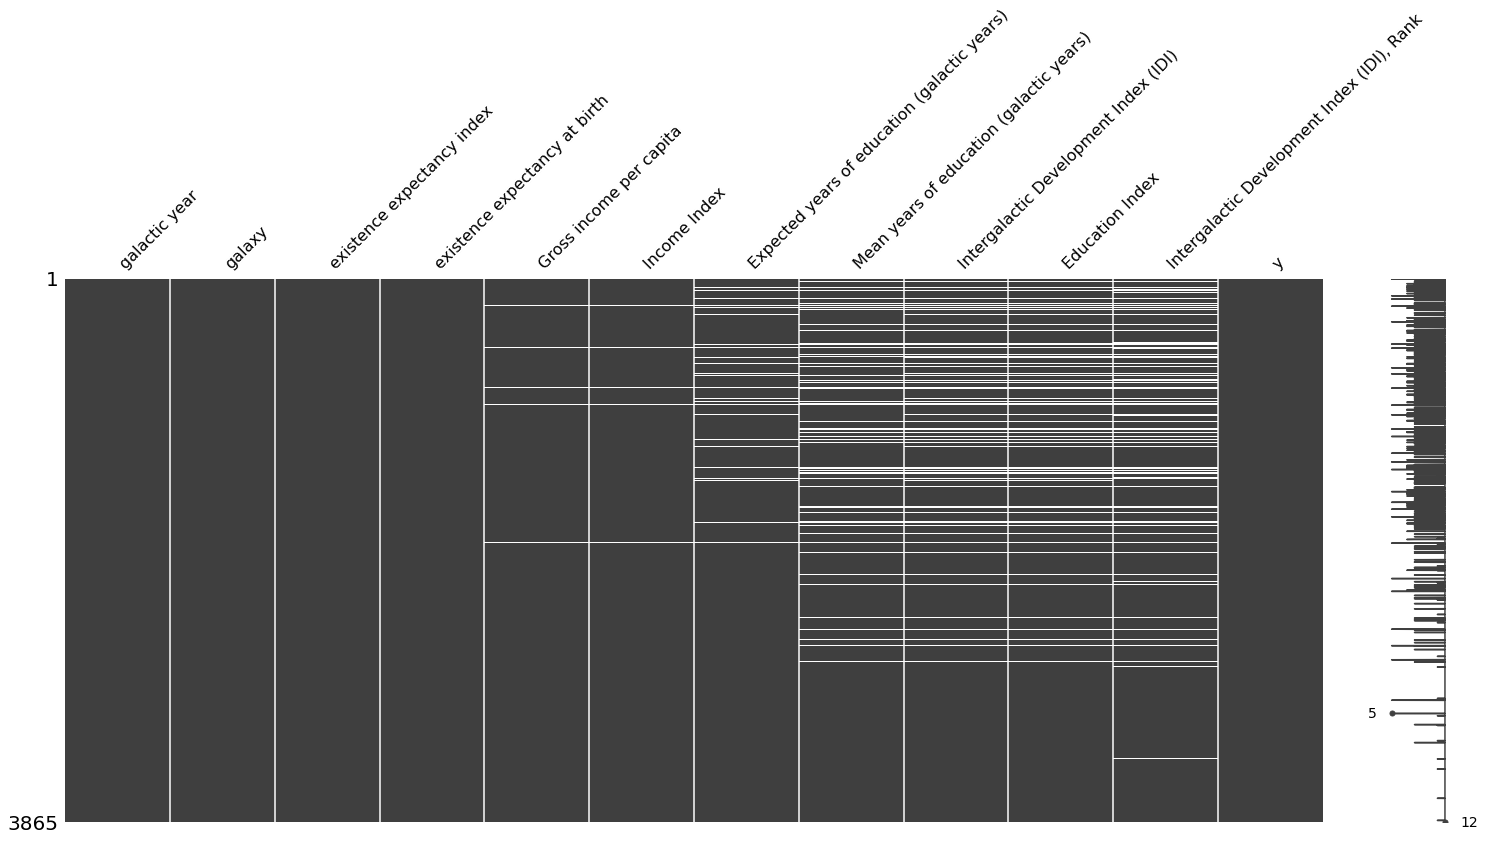

In [7]:
msno.matrix(df)

## Checking correlations between variables

C:\Users\elwin\AppData\Local\Temp/ipykernel_35244/1274048449.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))


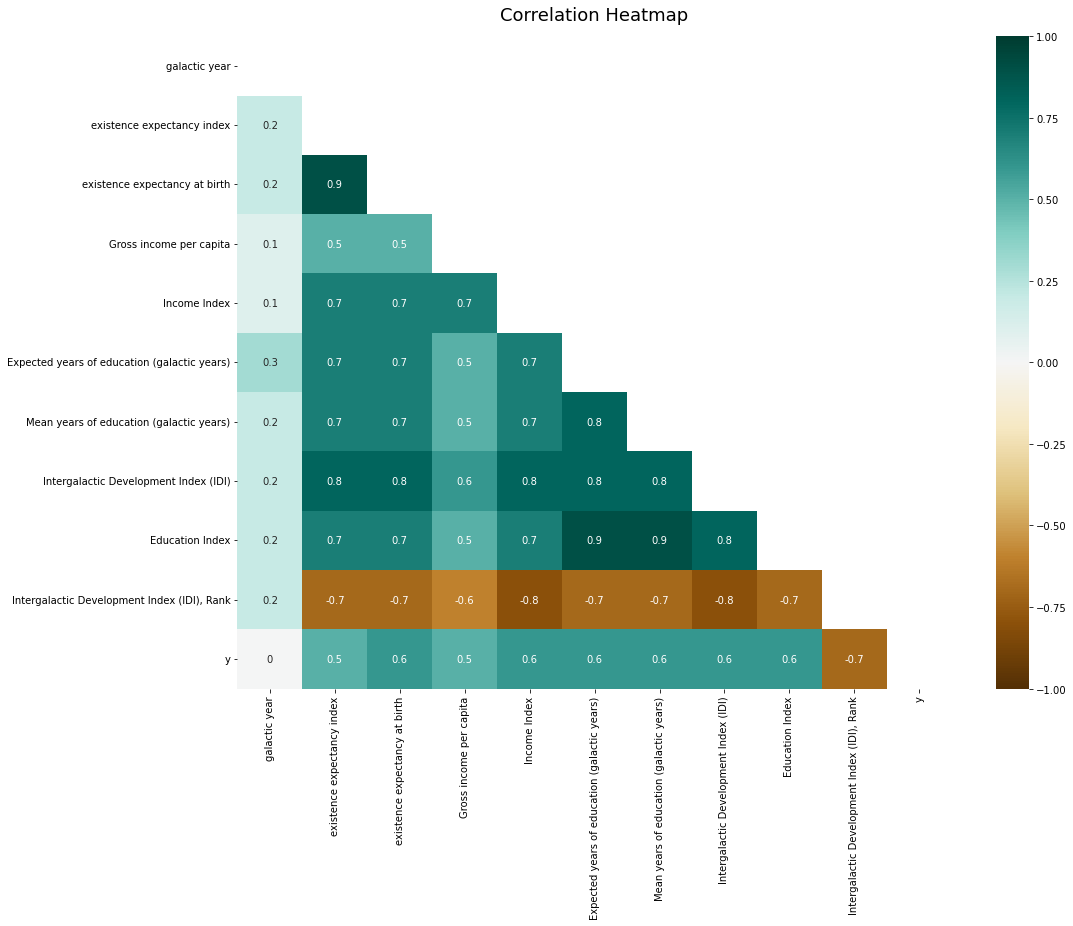

In [8]:
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(round(df.corr(),1), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
warnings.filterwarnings("ignore")

As we can see from correlation heatmap, galactic year has 0 correlation with our target, so we can drop this column

In [9]:
df.drop('galactic year', axis = 1, inplace = True)

IDI Rank is same thing as IDI, so in order to not deal with multicollinearity I have dropped this column

In [10]:
df.drop('Intergalactic Development Index (IDI), Rank', axis = 1, inplace = True)

In [11]:
df.drop('galaxy', axis = 1, inplace = True) 

## Plotting distribution of columns

array([[<AxesSubplot:title={'center':'existence expectancy index'}>,
        <AxesSubplot:title={'center':'existence expectancy at birth'}>,
        <AxesSubplot:title={'center':'Gross income per capita'}>],
       [<AxesSubplot:title={'center':'Income Index'}>,
        <AxesSubplot:title={'center':'Expected years of education (galactic years)'}>,
        <AxesSubplot:title={'center':'Mean years of education (galactic years)'}>],
       [<AxesSubplot:title={'center':'Intergalactic Development Index (IDI)'}>,
        <AxesSubplot:title={'center':'Education Index'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

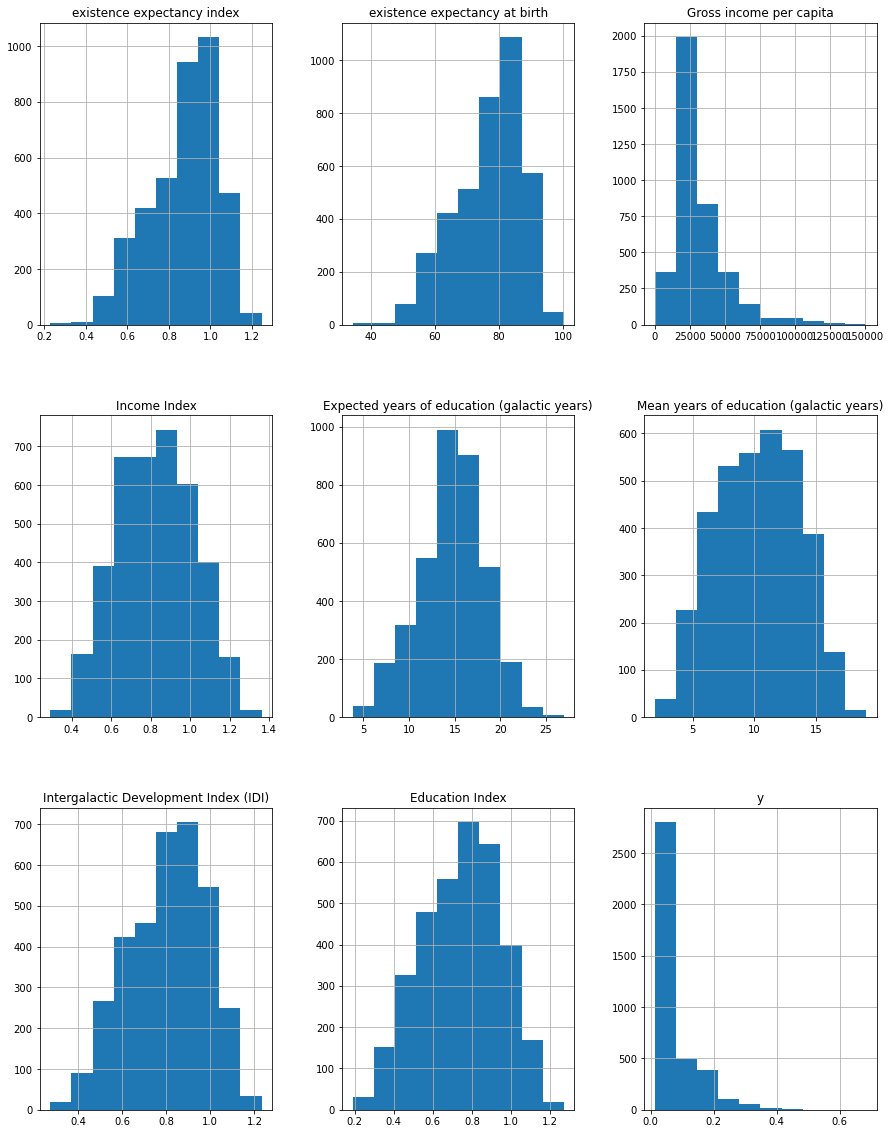

In [12]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.hist(ax = ax)

Most of the features are normally distributed, but there is also skewed features

# Data Preparation

## Selecting numeric columns to impute missing values

In [13]:
numeric_values = []
for i in df.columns:
    numeric_values.append(i)

In [14]:
for i in numeric_values:
    df.fillna(df[i].mean(), inplace=True)

## Splitting dataset to features and target

In [15]:
X = df.drop('y',axis = 1)
y = df['y']

## Splitting dataset to train and test (to be able to evaluate performance of model)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Scaling features to upgrade performance of model

In [17]:
robust = RobustScaler()

In [18]:
X_train.loc[:, X_train.columns] = robust.fit_transform(X_train)
X_test.loc[:, X_test.columns] = robust.transform(X_test)

# Modeling

In [19]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

# Evaluation

In [20]:
# Calculation of R2 and RMSE based on test dataset
R2 = r2_score(y_test, y_pred_test)
print('R^2:' , R2)
n = X_test.shape[0] #sample size
p = X_test.shape[1] #number of predictors

print('Adjusted R^2 :' , 1-(1-R2)*(n-1)/(n-p-1))
print('Root Mean Squared Error:' , np.sqrt(mean_squared_error(y_test, y_pred_test)))

R^2: 0.6895343799833074
Adjusted R^2 : 0.6862834310826089
Root Mean Squared Error: 0.034065202853426735


# Making predictions

In [21]:
valid_origin = pd.read_csv('test.csv')
validation = valid_origin.copy()

<AxesSubplot:>

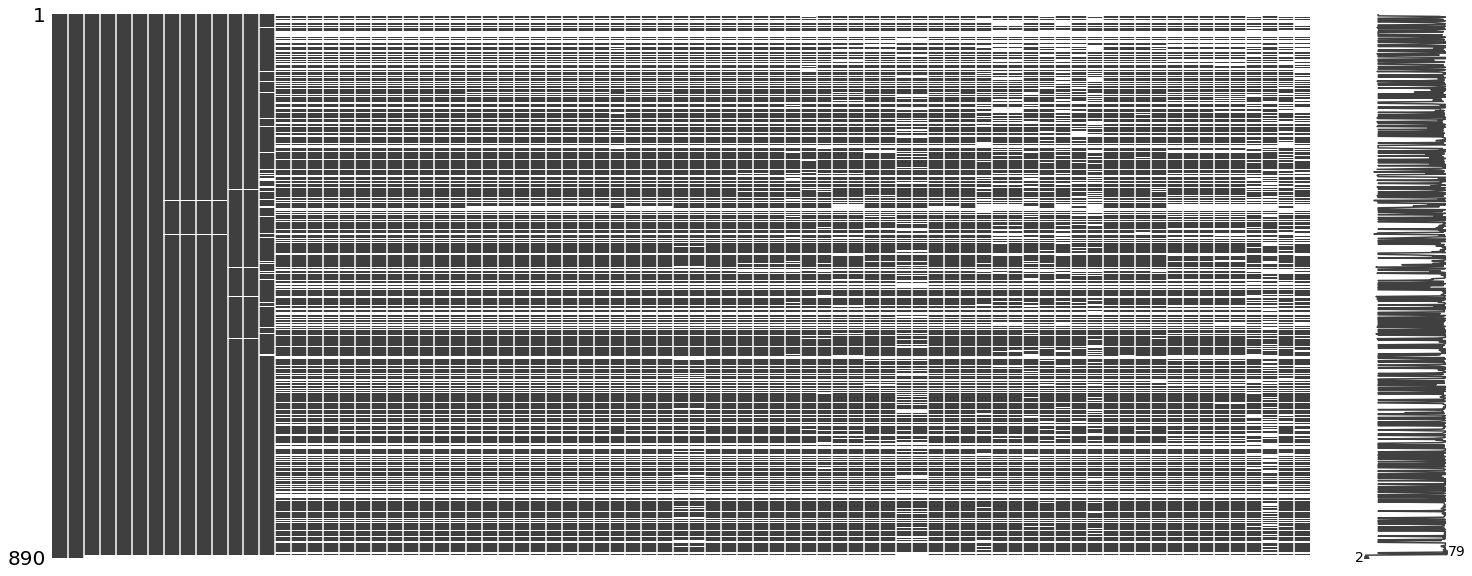

In [22]:
msno.matrix(validation)

In [23]:
validation_cols = []
for i in validation.columns:
    if i in numeric_values:
        validation_cols.append(i)

In [24]:
validation_cols

['existence expectancy index',
 'existence expectancy at birth',
 'Gross income per capita',
 'Income Index',
 'Expected years of education (galactic years)',
 'Mean years of education (galactic years)',
 'Intergalactic Development Index (IDI)',
 'Education Index']

In [25]:
for i in validation.columns:
    if i not in validation_cols:
        validation.drop(i, axis = 1, inplace = True)

In [26]:
validation.head(3)

,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index
0,0.456086,51.562543,12236.576447,0.593325,10.414164,10.699072,0.547114,0.556267
1,0.529835,57.228262,3431.883825,0.675407,7.239485,5.311122,0.497688,0.409969
2,0.560976,59.379539,27562.914252,0.594624,11.774890,5.937797,0.544744,0.486167


In [27]:
validation.loc[:, validation.columns] = robust.transform(validation)

In [28]:
valid_preds = xgb.predict(validation)

## Creating new dataset with needed features

In [29]:
pot_inc = -np.log(valid_preds+0.01)+3     # Potential for increase in the Index
p2= pot_inc**2                      # Likely increase in the Index

# creating dataframe with variables necessary for calculations
predictions = pd.DataFrame({
    'Index':validation.index,
    'galaxy':valid_origin.galaxy,
    'galactic year':valid_origin['galactic year'],
    'pred': valid_preds,
    'galactic year':valid_origin['galactic year'],
    'opt_pred':0,
})

To count optimized energy allocation I have decided to normalize predicted indexes, so we can allocate more energy to those galaxies, which have higher index. Also we should remember, that we can not give to one galaxy more than 100 DSMLs.

In [30]:
predictions['opt_pred'] = predictions['pred']*50000/predictions['pred'].sum()
for i in range(0, predictions.shape[0]):
    if predictions['opt_pred'][i] > 100:
        predictions['opt_pred'][i] = 99.9


In [31]:
predictions.groupby('galaxy')['opt_pred'].sum().max()

853.423828125

In [32]:
left_difference = 50000 - predictions['opt_pred'].sum()
print(left_difference)

4972.953125


We have 4972 zillions of energy left. Lets allocate more energy to those galaxies, which have less energy

(array([128., 235., 130.,  79.,  50.,  46.,  22.,  19.,  16., 165.]),
 array([17.640862, 25.866776, 34.09269 , 42.318604, 50.544518, 58.77043 ,
        66.996346, 75.22226 , 83.44817 , 91.67409 , 99.9     ],
       dtype=float32),
 <BarContainer object of 10 artists>)

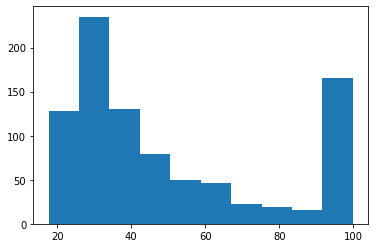

In [33]:
plt.hist(predictions['opt_pred'])

In [34]:
while predictions['opt_pred'].sum() <= 50000:
    for i in range(0, predictions.shape[0]):
            if predictions['opt_pred'][i] < 70:
                predictions['opt_pred'][i] += left_difference/predictions[predictions['opt_pred'] < 70].shape[0]

# Deployment

## Saving results to csv file

In [35]:
predictions.to_csv('predictions.csv', index = False)